# **LLM AVT Stable Diffusion**
This is a demo (intended to be run in Google Colab, with GPU enabled) of the audio-to-image models from our soon to be published research

## ***Testing chatbots on the creation of encoders for audio conditioned image generation***

by Jorge E. León (Universidad Adolfo Ibánez (UAI), Santiago, Chile) and Miguel Carrasco (Universidad Diego Portales (UDP), Santiago, Chile).

## Initial configuration (must be run before anything else) ☝

In [2]:
# @markdown First we download and load everything we need (this may take a few minutes and you need to run it two times).
import os
from IPython.display import clear_output

flag_file = './flag.txt'
if (not os.path.exists(flag_file)):
  # Libraries.
  !pip install diffusers==0.11.1
  !pip install transformers scipy ftfy accelerate torchview
  !pip install --upgrade diffusers transformers
  !pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  # Audio encoders.
  !git clone https://github.com/Jorvan758/A-SD-Alt.git
  # Hugging Face.
  !mkdir -p ~/.huggingface
  # @markdown Here you must paste your Hugging Face token (**and don't share that token publicly**).
  HUGGINGFACE_TOKEN = '' # @param {type:"string"}
  !echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token
  # Final touches.
  with open(flag_file, 'w') as opened_file: opened_file.write('.')
  clear_output()

print('Loading libraries...')
import torch, gc, torchaudio
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
from torchview import draw_graph
from scipy.io.wavfile import read
import matplotlib.pyplot as plt

selected_device = 'cuda' if torch.cuda.is_available() else 'cpu'
def clean_memory():
  gc.collect()
  if (selected_device == 'cuda'): torch.cuda.empty_cache()
parameters_folder = './A-SD-Alt/Models/'
sliced_models = './A-SD-Alt/Modelos_trozados/'
if (not os.path.exists(parameters_folder)): os.mkdir(parameters_folder)

final_files = list(set([final_file[:final_file.find('.part')] for final_file in os.listdir(sliced_models)]))
parts_per_file = {final_file: [a_file for a_file in os.listdir(sliced_models) if final_file in a_file] for final_file in final_files}
for part in parts_per_file: parts_per_file[part].sort()
for final_file in final_files:
  if (not os.path.exists(parameters_folder+final_file)):
    print(f'Working on {final_file}...')
    with open(parameters_folder+final_file, 'wb') as whole_out:
      for part in parts_per_file[final_file]:
        print(f'  ({part})')
        with open(sliced_models+part, 'rb') as part_in:
          data = part_in.read()
          whole_out.write(data)
print('All models restored.')

# Ours.
class HumanEncoder(torch.nn.Module):
  def __init__(self):
    super(HumanEncoder, self).__init__()
    ###
    self.usar_sesgos = True
    self.activacionSiLU = torch.nn.SiLU()
    self.dropout = torch.nn.Dropout(0.1)
    self.convolucion1d1 = torch.nn.Conv1d(1, 2, 25, stride=1, padding='same', bias=self.usar_sesgos)
    self.normalizacion1 = torch.nn.LayerNorm(16000)
    self.convolucion1d2 = torch.nn.Conv1d(2, 4, 25, stride=1, padding='same', bias=self.usar_sesgos)
    self.normalizacion2 = torch.nn.LayerNorm(16000)
    self.adaptador1 = torch.nn.Conv1d(1, 4, kernel_size=1, stride=1, padding='same', bias=self.usar_sesgos)
    self.convolucion1d3 = torch.nn.Conv1d(4, 8, 5, stride=1, padding='same', bias=self.usar_sesgos)
    self.normalizacion3 = torch.nn.LayerNorm(16000)
    self.convolucion1d4 = torch.nn.Conv1d(8, 16, 5, stride=1, padding='same', bias=self.usar_sesgos)
    self.normalizacion4 = torch.nn.LayerNorm(16000)
    self.adaptador2 = torch.nn.Conv1d(4, 16, kernel_size=1, stride=1, padding='same', bias=self.usar_sesgos)
    self.convolucion1d5 = torch.nn.Conv1d(16, 32, 3, stride=1, padding='same', bias=self.usar_sesgos)
    self.normalizacion5 = torch.nn.LayerNorm(16000)
    self.convolucion1d6 = torch.nn.Conv1d(32, 64, 3, stride=1, padding='same', bias=self.usar_sesgos)
    self.normalizacion6 = torch.nn.LayerNorm(16000)
    self.adaptador3 = torch.nn.Conv1d(16, 64, kernel_size=1, stride=1, padding='same', bias=self.usar_sesgos)
    self.convolucion1d7 = torch.nn.Conv1d(64, 77, 3, stride=1, padding='same', bias=self.usar_sesgos)
    self.normalizacion7 = torch.nn.LayerNorm(16000)
    self.adaptador4 = torch.nn.Conv1d(64, 77, kernel_size=1, stride=1, padding='same', bias=self.usar_sesgos)
    self.promedio = torch.nn.AdaptiveAvgPool1d(768)
    self.linealprom = torch.nn.Linear(768, 768, bias=self.usar_sesgos)
    self.adaptadorprom = torch.nn.Conv1d(77, 77, kernel_size=1, stride=1, padding='same', bias=self.usar_sesgos)
    self.maximo = torch.nn.AdaptiveMaxPool1d(768)
    self.linealmax = torch.nn.Linear(768, 768, bias=self.usar_sesgos)
    self.adaptadormax = torch.nn.Conv1d(77, 77, kernel_size=1, stride=1, padding='same', bias=self.usar_sesgos)
    self.minimo = torch.nn.AdaptiveMaxPool1d(768)
    self.linealmin = torch.nn.Linear(768, 768, bias=self.usar_sesgos)
    self.adaptadormin = torch.nn.Conv1d(77, 77, kernel_size=1, stride=1, padding='same', bias=self.usar_sesgos)
    torch.nn.init.kaiming_normal_(self.convolucion1d1.weight)
    torch.nn.init.kaiming_normal_(self.convolucion1d2.weight)
    torch.nn.init.kaiming_normal_(self.convolucion1d3.weight)
    torch.nn.init.kaiming_normal_(self.convolucion1d4.weight)
    torch.nn.init.kaiming_normal_(self.convolucion1d5.weight)
    torch.nn.init.kaiming_normal_(self.convolucion1d6.weight)
    torch.nn.init.kaiming_normal_(self.convolucion1d7.weight)
    torch.nn.init.kaiming_normal_(self.adaptador1.weight)
    torch.nn.init.kaiming_normal_(self.adaptador2.weight)
    torch.nn.init.kaiming_normal_(self.adaptador3.weight)
    torch.nn.init.kaiming_normal_(self.adaptador4.weight)
    torch.nn.init.kaiming_normal_(self.linealprom.weight)
    torch.nn.init.kaiming_normal_(self.linealmax.weight)
    torch.nn.init.kaiming_normal_(self.linealmin.weight)
    ###
  def forward(self, x):
    x = x.view((-1,1,16000))/32767
    ###
    residual1 = x
    x = self.convolucion1d1(x)
    x = self.activacionSiLU(x)
    x = self.normalizacion1(x)
    x = self.convolucion1d2(x)
    x = self.activacionSiLU(x)
    x = self.normalizacion2(x)
    x = self.dropout(x)
    x += self.adaptador1(residual1)
    residual2 = x
    x = self.convolucion1d3(x)
    x = self.activacionSiLU(x)
    x = self.normalizacion3(x)
    x = self.convolucion1d4(x)
    x = self.activacionSiLU(x)
    x = self.normalizacion4(x)
    x = self.dropout(x)
    x += self.adaptador2(residual2)
    residual3 = x
    x = self.convolucion1d5(x)
    x = self.activacionSiLU(x)
    x = self.normalizacion5(x)
    x = self.convolucion1d6(x)
    x = self.activacionSiLU(x)
    x = self.normalizacion6(x)
    x = self.dropout(x)
    x += self.adaptador3(residual3)
    residual4 = x
    x = self.convolucion1d7(x)
    x = self.activacionSiLU(x)
    x = self.normalizacion7(x)
    x = self.dropout(x)
    x += self.adaptador4(residual4)
    xprom = self.promedio(x)
    xmax = self.maximo(x)
    xmin = -self.minimo(-x)
    residualprom = xprom
    residualmax = xmax
    residualmin = xmin
    xprom = self.linealprom(xprom)
    xmax = self.linealmax(xmax)
    xmin = self.linealmin(xmin)
    x = xprom + xmax + xmin
    x += self.adaptadorprom(residualprom) + self.adaptadormin(residualmin) + self.adaptadormax(residualmax)
    ###
    assert (x.shape[1:] == (77, 768)), f"Expected shape (-1, 77, 768), but got {x.shape}."
    return x
  def predict(self, x):
    with torch.no_grad(): return self.forward(x)
  def load_parameters(self):
    self.load_state_dict(torch.load(f'{parameters_folder}Human.pth', weights_only=False, map_location=torch.device(selected_device)))
# ChatGPT o3-mini.
class ChatgptEncoder(torch.nn.Module):
  def __init__(self):
    super(ChatgptEncoder, self).__init__()
    ###
    self.num_patches = 77
    self.patch_size = 208
    self.proj = torch.nn.Conv1d(
      in_channels=1,
      out_channels=768,
      kernel_size=self.patch_size,
      stride=self.patch_size
    )
    self.pos_embed = torch.nn.Parameter(torch.zeros(self.num_patches, 768))
    encoder_layer = torch.nn.TransformerEncoderLayer(
      d_model=768,
      nhead=12,
      dropout=0.1,
      activation='gelu'
    )
    self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=4)
    self.dropout = torch.nn.Dropout(0.1)
    ###
  def forward(self, x):
    x = x.view((-1,1,16000))/32767
    ###
    required_length = self.num_patches * self.patch_size  # 16016
    if x.shape[2] < required_length:
      pad_amount = required_length - x.shape[2]
      x = torch.nn.functional.pad(x, (0, pad_amount), mode='constant', value=0)
    x = self.proj(x)
    x = x.transpose(1, 2)
    x = x + self.pos_embed
    x = self.dropout(x)
    x = x.transpose(0, 1)
    x = self.transformer(x)
    x = x.transpose(0, 1)
    ###
    assert (x.shape[1:] == (77, 768)), f"Expected shape (-1, 77, 768), but got {x.shape}."
    return x
  def predict(self, x):
    with torch.no_grad(): return self.forward(x)
  def load_parameters(self):
    self.load_state_dict(torch.load(f'{parameters_folder}Chatgpt.pth', weights_only=False, map_location=torch.device(selected_device)))
# DeepSeek-R1.
class DeepseekEncoder(torch.nn.Module):
  def __init__(self):
    super(DeepseekEncoder, self).__init__()
    ###
    self.conv1 = torch.nn.Conv1d(1, 768, kernel_size=208, stride=208)
    self.positional_embedding = torch.nn.Parameter(torch.randn(1, 77, 768))
    encoder_layer = torch.nn.TransformerEncoderLayer(
      d_model=768,
      nhead=12,
      dim_feedforward=3072,
      dropout=0.1,
      activation='gelu',
      batch_first=True
    )
    self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers=12)
    ###
  def forward(self, x):
    x = x.view((-1,1,16000))/32767
    ###
    x = torch.nn.functional.pad(x, (0, 16))
    x = self.conv1(x)
    x = x.transpose(1, 2)
    x += self.positional_embedding
    x = self.transformer(x)
    ###
    assert (x.shape[1:] == (77, 768)), f"Expected shape (-1, 77, 768), but got {x.shape}."
    return x
  def predict(self, x):
    with torch.no_grad(): return self.forward(x)
  def load_parameters(self):
    self.load_state_dict(torch.load(f'{parameters_folder}Deepseek.pth', weights_only=False, map_location=torch.device(selected_device)))
# Gemini 2.5 Pro Preview 03-25.
class GeminiEncoder(torch.nn.Module):
  def __init__(self):
    super(GeminiEncoder, self).__init__()
    ###
    self.sample_rate = 16000
    self.output_seq_len = 77
    self.embed_dim = 768
    self.n_mels = 80
    self.n_fft = 1024
    self.hop_length = self.sample_rate // (self.output_seq_len - 1)
    self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
      sample_rate=self.sample_rate,
      n_fft=self.n_fft,
      hop_length=self.hop_length,
      n_mels=self.n_mels,
      center=True,
      power=2.0
    )
    self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)
    self.input_projection = torch.nn.Linear(self.n_mels, self.embed_dim)
    self.positional_embedding = torch.nn.Parameter(torch.randn(1, self.output_seq_len, self.embed_dim))
    encoder_layer = torch.nn.TransformerEncoderLayer(
      d_model=self.embed_dim,
      nhead=12,
      dim_feedforward=self.embed_dim * 4,
      dropout=0.1,
      activation='gelu',
      batch_first=True,
      norm_first=True
    )
    num_encoder_layers = 8
    self.transformer_encoder = torch.nn.TransformerEncoder(
      encoder_layer,
      num_layers=num_encoder_layers,
      norm=torch.nn.LayerNorm(self.embed_dim)
    )
    self.apply(self._init_weights)
  def _init_weights(self, module):
    if isinstance(module, (torch.nn.Linear, torch.nn.Conv1d, torch.nn.Conv2d)):
      torch.nn.init.xavier_uniform_(module.weight, gain=torch.nn.init.calculate_gain('relu'))
      if module.bias is not None:
        torch.nn.init.constant_(module.bias, 0)
    elif isinstance(module, torch.nn.LayerNorm):
      torch.nn.init.constant_(module.bias, 0)
      torch.nn.init.constant_(module.weight, 1.0)
    elif isinstance(module, torch.nn.Parameter) and module.ndim > 1:
      torch.nn.init.xavier_uniform_(module, gain=torch.nn.init.calculate_gain('relu'))
    ###
  def forward(self, x):
    x = x.view((-1,1,16000))/32767
    ###
    if x.dim() == 3 and x.shape[1] == 1:
      x = x.squeeze(1)
    elif x.dim() != 2:
      raise ValueError(f"Unexpected input shape: {x.shape}")
    mel_spec = self.mel_spectrogram(x)
    mel_spec = self.amplitude_to_db(mel_spec)
    mean = mel_spec.mean(dim=(-1, -2), keepdim=True)
    std = mel_spec.std(dim=(-1, -2), keepdim=True)
    mel_spec = (mel_spec - mean) / (std + 1e-6)
    mel_spec = mel_spec.permute(0, 2, 1)
    x = self.input_projection(mel_spec)
    x = x + self.positional_embedding
    x = self.transformer_encoder(x)
    ###
    assert (x.shape[1:] == (77, 768)), f"Expected shape (-1, 77, 768), but got {x.shape}."
    return x
  def predict(self, x):
    with torch.no_grad(): return self.forward(x)
  def load_parameters(self):
    self.load_state_dict(torch.load(f'{parameters_folder}Gemini.pth', weights_only=False, map_location=torch.device(selected_device)))
# Grok 3.
class GrokEncoder(torch.nn.Module):
  def __init__(self):
    super(GrokEncoder, self).__init__()
    ###
    self.register_buffer('window', torch.hann_window(256))
    self.linear = torch.nn.Linear(129, 768)
    self.pos_emb = torch.nn.Parameter(torch.randn(77, 768))
    layer = torch.nn.TransformerEncoderLayer(d_model=768, nhead=12, dim_feedforward=3072, activation='gelu', batch_first=True)
    self.transformer = torch.nn.TransformerEncoder(layer, num_layers=12)
    ###
  def forward(self, x):
    x = x.view((-1,1,16000))/32767
    ###
    x = x.squeeze(1)
    stft = torch.stft(x, n_fft=256, hop_length=207, win_length=256, window=self.window, center=False, return_complex=True)
    mag = torch.abs(stft)
    log_mag = torch.log(1 + mag)
    log_mag = log_mag.permute(0, 2, 1)
    emb = self.linear(log_mag)
    emb = emb + self.pos_emb
    x = self.transformer(emb)
    ###
    assert (x.shape[1:] == (77, 768)), f"Expected shape (-1, 77, 768), but got {x.shape}."
    return x
  def predict(self, x):
    with torch.no_grad(): return self.forward(x)
  def load_parameters(self):
    self.load_state_dict(torch.load(f'{parameters_folder}Grok.pth', weights_only=False, map_location=torch.device(selected_device)))



vae = AutoencoderKL.from_pretrained('stable-diffusion-v1-5/stable-diffusion-v1-5', subfolder='vae')
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
human_encoder = HumanEncoder().to(selected_device)
chatgpt_encoder = ChatgptEncoder().to(selected_device)
deepseek_encoder = DeepseekEncoder().to(selected_device)
gemini_encoder = GeminiEncoder().to(selected_device)
grok_encoder = GrokEncoder().to(selected_device)
human_encoder.load_parameters()
chatgpt_encoder.load_parameters()
deepseek_encoder.load_parameters()
gemini_encoder.load_parameters()
grok_encoder.load_parameters()
audio_encoders = {'Human': chatgpt_encoder,
                  'ChatGPT': chatgpt_encoder,
                  'DeepSeek': deepseek_encoder,
                  'Gemini': gemini_encoder,
                  'Grok': grok_encoder}
unet = UNet2DConditionModel.from_pretrained('stable-diffusion-v1-5/stable-diffusion-v1-5', subfolder='unet')
scheduler = LMSDiscreteScheduler.from_pretrained('stable-diffusion-v1-5/stable-diffusion-v1-5', subfolder='scheduler')
vae = vae.to(selected_device)
text_encoder = text_encoder.to(selected_device)
unet = unet.to(selected_device)
clear_output()
print("You're ready to go!")

You're ready to go!


## Seeing the architectures 📊

In [ ]:
# @markdown Select the encoder you wish to display (it wil consider a batch of 1 sample as input).
SELECTED_AUDIO_ENCODER = 'Human' # @param ["Human", "ChatGPT", "DeepSeek", "Gemini", "Grok"]

encoder_graph = draw_graph(
    audio_encoders[SELECTED_AUDIO_ENCODER],
    input_size=(1, 16000),
    device='meta',
)

encoder_graph.visual_graph

## Generating images 🎨

  0%|          | 0/140 [00:00<?, ?it/s]

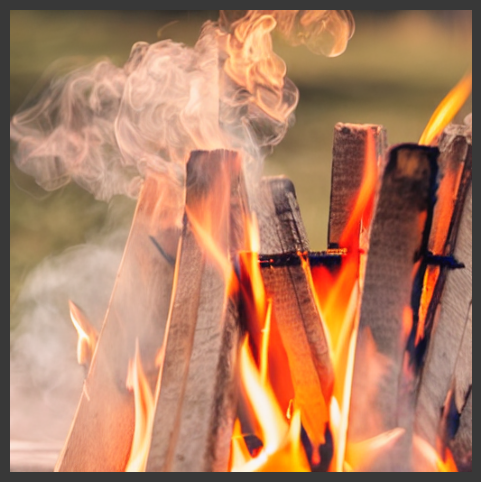

In [4]:
# @title Now you can create images using any combination of the encoders.
# Configurable parameters.
# @markdown Select the image you want to give as input (leave it empty if you don't want to condition the generation with an image).
image_path = './A-SD-Alt/Referencias/1.png' # @param {type:'string', placeholder:'(Remember to add the extension .png or .jpg)'}
# @markdown Select the 1 second audio with 16,000 Hz you want to give as input (leave it empty if you don't want to condition the generation with an audio).
audio_path = './A-SD-Alt/Referencias/a bonfire.wav' # @param {type:'string', placeholder:'(Remember to add the extension .wav)'}
# @markdown Write the text you want to give as input (leave it empty if you don't want to condition the generation with a text).
text_prompt = 'A bonfire' # @param {type:'string', placeholder:'(Only the first 77 tokens will be considered)'}
# @markdown Select the dimensions of the output image (if you give a image as input, keep it in mind so it doesn't get distorted).
output_height = 512 # @param {type:'integer', placeholder:'(Multiples of 8 give better results)'}
output_width = 512 # @param {type:'integer', placeholder:'(Multiples of 8 give better results)'}
# @markdown A higher number of denoising steps should give a sharper image, but taking a longer time.
number_of_denoising_steps = 200 # @param {type:'integer', placeholder:'(If you are using an image as input, we suggest 200; otherwise, 100 should be enough)'}
# @markdown A higher guidance scale implies that the output will closer resemble your input audio/text.
guidance_scale = 10 # @param {type:'number', placeholder:'(If you are using an image as input, we suggest 10; otherwise, 7.5 should be enough)'}
# @markdown A higher strength implies that the output will closer resemble your input image (ignore it if you aren't using an input image).
strength = 0.7 # @param {type:'number', placeholder:'(0.7 should be enough)'}
# @markdown Number of copies control the number of different images to generate in one pass.
number_of_copies = 1 # @param {type:'integer', placeholder:'(If your hardware is limited, just use 1)'}
# @markdown Change the random seed to obtain different results.
the_random_seed = 7 # @param {type:'integer'}
# @markdown A higher print scale displays the output images at a greater resolution.
print_scale = 6 # @param {type:'number', placeholder:'(6 should be enough)'}
# @markdown Select the audio encoders you want to use in the generation.
use_human_encoder = False # @param {type:'boolean'}
use_chatgpt_encoder = False # @param {type:'boolean'}
use_deepseek_encoder = False # @param {type:'boolean'}
use_gemini_encoder = False # @param {type:'boolean'}
use_grok_encoder = False # @param {type:'boolean'}
if (image_path != ''):
  base_image = (np.array([Image.open(image_path).resize((output_width, output_height))]*number_of_copies)[:,:,:,:3].transpose(0, 3, 1, 2)/255 - 0.5)*2
if (audio_path != ''):
  base_audio = torch.tensor(np.array(read(audio_path)[1],dtype=float).astype(int), requires_grad=False, dtype=torch.float32).to(selected_device)
generator = torch.manual_seed(the_random_seed)
# Generating embeddings.
conditional_embeddings = torch.zeros((number_of_copies,77,768)).to(selected_device)
unconditional_embeddings = torch.zeros((number_of_copies,77,768)).to(selected_device)
resulting_embeddings = torch.zeros((2*number_of_copies,77,768)).to(selected_device)
with torch.no_grad():
  denominator = int(use_human_encoder)+int(use_chatgpt_encoder)+int(use_deepseek_encoder)+int(use_gemini_encoder)+int(use_grok_encoder)
  # Audio.
  if ((audio_path != '') and (denominator > 0)):
    the_zeros = torch.zeros((number_of_copies, 16000)).to(selected_device)
    if (use_human_encoder):
      conditional_embeddings += human_encoder.predict(base_audio).repeat(1, number_of_copies, 1).view(number_of_copies, 77, -1).to(selected_device)
      unconditional_embeddings += human_encoder.predict(the_zeros).to(selected_device)
    if (use_chatgpt_encoder):
      conditional_embeddings += chatgpt_encoder.predict(base_audio).repeat(1, number_of_copies, 1).view(number_of_copies, 77, -1).to(selected_device)
      unconditional_embeddings += chatgpt_encoder.predict(the_zeros).to(selected_device)
    if (use_deepseek_encoder):
      conditional_embeddings += deepseek_encoder.predict(base_audio).repeat(1, number_of_copies, 1).view(number_of_copies, 77, -1).to(selected_device)
      unconditional_embeddings += deepseek_encoder.predict(the_zeros).to(selected_device)
    if (use_gemini_encoder):
      conditional_embeddings += gemini_encoder.predict(base_audio).repeat(1, number_of_copies, 1).view(number_of_copies, 77, -1).to(selected_device)
      unconditional_embeddings += gemini_encoder.predict(the_zeros).to(selected_device)
    if (use_grok_encoder):
      conditional_embeddings += grok_encoder.predict(base_audio).repeat(1, number_of_copies, 1).view(number_of_copies, 77, -1).to(selected_device)
      unconditional_embeddings += grok_encoder.predict(the_zeros).to(selected_device)
    resulting_embeddings = torch.cat([unconditional_embeddings/denominator, conditional_embeddings/denominator])
    del the_zeros, base_audio
  # Text.
  denominator = int(use_human_encoder or use_chatgpt_encoder or use_deepseek_encoder or use_gemini_encoder or use_grok_encoder) + 1
  if (text_prompt != ''):
    tokenized_prompt = tokenizer(text_prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    max_prompt_length = tokenized_prompt.input_ids.shape[-1]
    tokenized_empty = tokenizer(['']*number_of_copies, padding='max_length', max_length=max_prompt_length, return_tensors="pt")
    with torch.no_grad():
      conditional_embeddings = text_encoder(tokenized_prompt.input_ids.to(selected_device))[0]
      unconditional_embeddings = text_encoder(tokenized_empty.input_ids.to(selected_device))[0]
    conditional_embeddings = conditional_embeddings.repeat(1, number_of_copies, 1)
    conditional_embeddings = conditional_embeddings.view(number_of_copies, 77, -1)
    resulting_embeddings += torch.cat([unconditional_embeddings, conditional_embeddings])
    resulting_embeddings = resulting_embeddings/denominator
    del tokenized_prompt, max_prompt_length, tokenized_empty
  # Random.
  if (((audio_path == '') or (denominator == 1)) and (text_prompt == '')):
    resulting_embeddings = torch.Tensor(np.random.normal(0, 1, (2*number_of_copies, 77, 768))).to(selected_device)
del conditional_embeddings, unconditional_embeddings, denominator
# The image to denoise is prepared.
scheduler.set_timesteps(number_of_denoising_steps)
if (image_path == ''):
  initial_step = number_of_denoising_steps
  latent_encoding = torch.randn((number_of_copies, unet.in_channels, output_height//8, output_width//8), generator=generator).to(selected_device)*scheduler.init_noise_sigma
else:
  latent_encoding = vae.encode(torch.tensor(base_image).type(torch.float).to(selected_device)).latent_dist.sample()*0.18215
  initial_step = min(int(number_of_denoising_steps*strength), number_of_denoising_steps)
  iterations = scheduler.timesteps[-initial_step].repeat(number_of_copies).to(selected_device)
  added_noise = torch.randn(latent_encoding.shape, generator=generator, device='cpu').to(selected_device)
  latent_encoding = scheduler.add_noise(latent_encoding, added_noise, iterations).to(selected_device)
  del base_image, added_noise, iterations
clean_memory()
# The latent image is denoised.
for t in tqdm(scheduler.timesteps[-initial_step:]):
  latent_image = scheduler.scale_model_input(torch.cat([latent_encoding]*2), t)
  with torch.no_grad(): predicted_noise = unet(latent_image, t, encoder_hidden_states=resulting_embeddings).sample
  unconditioned_predicted_noise, conditioned_predicted_noise = predicted_noise.chunk(2)
  predicted_noise = unconditioned_predicted_noise + guidance_scale*(conditioned_predicted_noise-unconditioned_predicted_noise)
  latent_encoding = scheduler.step(predicted_noise, t, latent_encoding).prev_sample
del resulting_embeddings, predicted_noise, unconditioned_predicted_noise, conditioned_predicted_noise
clean_memory()
# The resulting image is decoded.
latent_encoding = latent_encoding/0.18215
with torch.no_grad(): final_images = vae.decode(latent_encoding).sample
del latent_encoding
clean_memory()
final_images = (final_images / 2 + 0.5).clamp(0, 1)
final_images = final_images.detach().cpu().permute(0, 2, 3, 1).numpy()
final_images = (final_images * 255).round().astype('uint8')
final_images = [Image.fromarray(final_image) for final_image in final_images]
for final_image in final_images:
  figura = plt.figure(figsize=(print_scale*output_width/max(output_width, output_height),print_scale*output_height/max(output_width, output_height)))
  figura.set_facecolor((56/255, 56/255, 56/255, 1))
  plt.imshow(final_image)
  plt.axis('off')
  plt.show()